# LSTM simple sur du texte (sans transformers)

## Objectifs
 - Construire un petit corpus texte (quelques phrases en français)
- Tokeniser au niveau CARACTÈRES (alphabet réduit)
- Encoder texte -> IDs -> tenseurs
- Construire un modèle LSTM simple pour prédire le prochain caractère
- Visualiser la courbe de perte
- Générer du texte à partir d'un "prompt" (phrase de départ)


In [22]:

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

# Petit corpus: quelques phrases simples

In [3]:
corpus_sentences = [
    "les modeles de langage sont puissants.",
    "les reseaux LSTM traitent des sequences.",
    "les transformers utilisent l'attention.",
    "les grands modeles de langage sont couteux.",
]

# On concatène tout en une seule longue chaîne
text = " ".join(corpus_sentences)
print("Texte brut :")
print(text)
print("\nLongueur totale :", len(text))


Texte brut :
les modeles de langage sont puissants. les reseaux LSTM traitent des sequences. les transformers utilisent l'attention. les grands modeles de langage sont couteux.

Longueur totale : 163


# Construire le vocabulaire de caractères

In [4]:
chars = sorted(list(set(text)))
vocab_size = len(chars)

print("Caractères du vocabulaire :")
print(chars)
print("Taille du vocabulaire :", vocab_size)

# Mappings char <-> id
char2idx = {ch: i for i, ch in enumerate(chars)}
idx2char = {i: ch for ch, i in char2idx.items()}

# Encodage du texte complet en IDs
encoded = np.array([char2idx[ch] for ch in text], dtype=np.int64)
print("\nDébut du texte encodé :")
print(encoded[:50])


Caractères du vocabulaire :
[' ', "'", '.', 'L', 'M', 'S', 'T', 'a', 'c', 'd', 'e', 'f', 'g', 'i', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'x']
Taille du vocabulaire : 25

Début du texte encodé :
[14 10 21  0 15 17  9 10 14 10 21  0  9 10  0 14  7 16 12  7 12 10  0 21
 17 16 22  0 18 23 13 21 21  7 16 22 21  2  0 14 10 21  0 20 10 21 10  7
 23 24]


# Construction des séquences pour LSTM (fenêtres + cible)

In [5]:
def make_char_sequences(encoded_text, seq_len=30):
    """
    encoded_text : array 1D d'IDs de caractères
    seq_len      : longueur de la séquence d'entrée

    Retourne :
      X : (N, seq_len)
      y : (N,)  (ID du caractère à prédire)
    """
    X = []
    y = []
    for start in range(0, len(encoded_text) - seq_len):
        end = start + seq_len
        X.append(encoded_text[start:end])
        y.append(encoded_text[end])   # prochain char
    return np.array(X, dtype=np.int64), np.array(y, dtype=np.int64)

SEQ_LEN = 30
X_np, y_np = make_char_sequences(encoded, seq_len=SEQ_LEN)

print("Shape X :", X_np.shape)  # (N, seq_len)
print("Shape y :", y_np.shape)  # (N,)


Shape X : (133, 30)
Shape y : (133,)


# Visualisation de quelques séquences + cible associée :

In [6]:
def decode_ids(ids):
    return "".join(idx2char[int(i)] for i in ids)

print("Quelques exemples (séquence -> cible) :\n")
for i in range(5):
    seq_str = decode_ids(X_np[i])
    target_str = idx2char[y_np[i]]
    print(f"[{i}] \"{seq_str}\"  -->  cible : \"{target_str}\"")


Quelques exemples (séquence -> cible) :

[0] "les modeles de langage sont pu"  -->  cible : "i"
[1] "es modeles de langage sont pui"  -->  cible : "s"
[2] "s modeles de langage sont puis"  -->  cible : "s"
[3] " modeles de langage sont puiss"  -->  cible : "a"
[4] "modeles de langage sont puissa"  -->  cible : "n"


# Dataset / DataLoader PyTorch

In [7]:
class CharDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)          # (N, seq_len)
        self.y = torch.from_numpy(y)          # (N,)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # On renvoie la séquence et la cible
        return self.X[idx], self.y[idx]

dataset = CharDataset(X_np, y_np)

BATCH_SIZE = 32
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Vérification des shapes
for batch_X, batch_y in loader:
    print("Batch X shape :", batch_X.shape)   # (B, seq_len)
    print("Batch y shape :", batch_y.shape)   # (B,)
    break


Batch X shape : torch.Size([32, 30])
Batch y shape : torch.Size([32])


# Modèle LSTM simple pour texte (caractères)

In [ ]:
class CharLSTM(nn.Module):
    def __init__(self, vocab_size, emb_dim=32, hidden_size=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_size,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        """
        x : (B, T) -> séquence d'IDs de caractères
        """
        emb = self.embedding(x)     # (B, T, emb_dim)
        out, (h_n, c_n) = self.lstm(emb)  # out: (B, T, hidden), h_n: (1, B, hidden)
        last_out = out[:, -1, :]    # on ne garde que le dernier pas de temps (B, hidden)
        logits = self.fc(last_out)  # (B, vocab_size)
        return logits

model = CharLSTM(vocab_size=vocab_size, emb_dim=32, hidden_size=64).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model


# Entraînement du LSTM

In [10]:
NUM_EPOCHS = 100

losses = []

model.train()
for epoch in range(1, NUM_EPOCHS + 1):
    epoch_loss = 0.0
    for batch_X, batch_y in loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        logits = model(batch_X)             # (B, vocab_size)
        loss = criterion(logits, batch_y)   # cross-entropy
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * batch_X.size(0)

    epoch_loss /= len(dataset)
    losses.append(epoch_loss)
    print(f"Epoch {epoch:02d} - Loss = {epoch_loss:.4f}")


Epoch 01 - Loss = 0.1798
Epoch 02 - Loss = 0.1591
Epoch 03 - Loss = 0.1483
Epoch 04 - Loss = 0.1346
Epoch 05 - Loss = 0.1244
Epoch 06 - Loss = 0.1063
Epoch 07 - Loss = 0.0976
Epoch 08 - Loss = 0.0910
Epoch 09 - Loss = 0.0808
Epoch 10 - Loss = 0.0726
Epoch 11 - Loss = 0.0663
Epoch 12 - Loss = 0.0701
Epoch 13 - Loss = 0.0638
Epoch 14 - Loss = 0.0548
Epoch 15 - Loss = 0.0471
Epoch 16 - Loss = 0.0424
Epoch 17 - Loss = 0.0427
Epoch 18 - Loss = 0.0429
Epoch 19 - Loss = 0.0356
Epoch 20 - Loss = 0.0311
Epoch 21 - Loss = 0.0278
Epoch 22 - Loss = 0.0264
Epoch 23 - Loss = 0.0239
Epoch 24 - Loss = 0.0295
Epoch 25 - Loss = 0.0228
Epoch 26 - Loss = 0.0213
Epoch 27 - Loss = 0.0192
Epoch 28 - Loss = 0.0180
Epoch 29 - Loss = 0.0171
Epoch 30 - Loss = 0.0163
Epoch 31 - Loss = 0.0156
Epoch 32 - Loss = 0.0149
Epoch 33 - Loss = 0.0142
Epoch 34 - Loss = 0.0136
Epoch 35 - Loss = 0.0130
Epoch 36 - Loss = 0.0126
Epoch 37 - Loss = 0.0122
Epoch 38 - Loss = 0.0116
Epoch 39 - Loss = 0.0110
Epoch 40 - Loss = 0.0107


# Visualisation de la courbe de perte

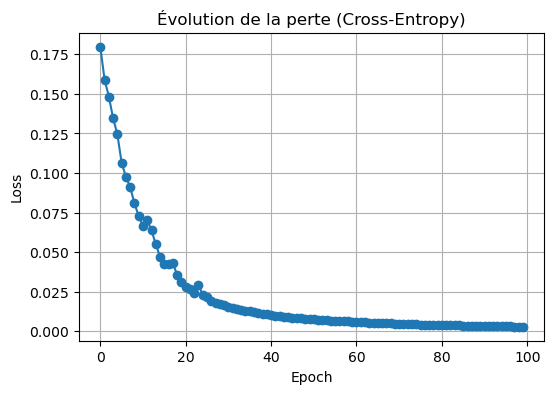

In [11]:
plt.figure(figsize=(6,4))
plt.plot(losses, marker="o")
plt.title("Évolution de la perte (Cross-Entropy)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


# Fonction de génération de texte (mode inference)

In [12]:
def generate_text(model, seed_text, length=200, temperature=1.0):
    """
    seed_text : texte de départ (string)
    length    : nombre de caractères à générer
    temperature : contrôle la "créativité" du sampling
    """
    model.eval()
    generated = seed_text

    # On part des derniers SEQ_LEN chars (ou moins si seed plus court)
    seed_encoded = [char2idx[ch] for ch in seed_text if ch in char2idx]
    if len(seed_encoded) == 0:
        raise ValueError("Seed text vide ou caractères inconnus.")
    
    input_ids = torch.tensor(seed_encoded[-SEQ_LEN:], dtype=torch.long).unsqueeze(0).to(device)

    for _ in range(length):
        with torch.no_grad():
            logits = model(input_ids)  # (1, vocab_size)
        
        # On applique une température
        logits = logits[0] / temperature
        probs = torch.softmax(logits, dim=-1)
        
        # Sampling
        next_id = torch.multinomial(probs, num_samples=1).item()
        next_char = idx2char[next_id]
        generated += next_char

        # On met à jour la séquence d'entrée (fenêtre glissante)
        next_input = torch.tensor([[next_id]], dtype=torch.long, device=device)
        input_ids = torch.cat([input_ids[:,1:], next_input], dim=1)

    return generated


# Exemple de génération

In [18]:
seed = "Les modeles "
print("Seed :", repr(seed))

gen_text = generate_text(model, seed_text=seed, length=200, temperature=0.8)
print("\nTexte généré :\n")
print(gen_text)


Seed : 'Les modeles '

Texte généré :

Les modeles de langage sont couteux. les transformers utilisent l'attention. les reseaux LSTM traitent des sequences. les transformers utilisent l'attention. les reseaux LSTM traitent des sequences. les transform


# Visualiser une séquence d’entrée comme matrice (IDs & embeddings)

In [14]:
# On prend une séquence de test
seq_ids = X_np[0]  # (SEQ_LEN,)
print("Séquence (IDs) :", seq_ids)
print("Séquence (texte) :", decode_ids(seq_ids))

# Passage par embedding
model.eval()
with torch.no_grad():
    x_tensor = torch.from_numpy(seq_ids).unsqueeze(0).to(device)  # (1, T)
    emb = model.embedding(x_tensor)                               # (1, T, emb_dim)

emb_np = emb.squeeze(0).cpu().numpy()  # (T, emb_dim)
print("\nShape du tenseur d'embedding :", emb_np.shape)


Séquence (IDs) : [14 10 21  0 15 17  9 10 14 10 21  0  9 10  0 14  7 16 12  7 12 10  0 21
 17 16 22  0 18 23]
Séquence (texte) : les modeles de langage sont pu

Shape du tenseur d'embedding : (30, 32)


# Norme des vecteurs d’embedding par position

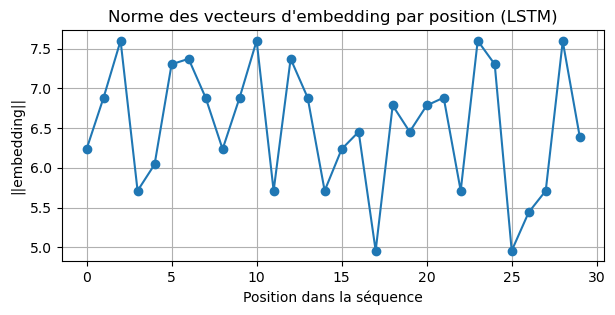

In [15]:
norms = np.linalg.norm(emb_np, axis=1)

plt.figure(figsize=(7,3))
plt.plot(range(SEQ_LEN), norms, marker="o")
plt.title("Norme des vecteurs d'embedding par position (LSTM)")
plt.xlabel("Position dans la séquence")
plt.ylabel("||embedding||")
plt.grid(True)
plt.show()
